In [182]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import db_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
from matplotlib.ticker import FuncFormatter

def exp_format(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return int(np.exp(x))

In [287]:
def _plot_constraint_scores(ax, perps, s_all_means, s_ml_means, s_cl_means, dataset_name, last_row=True):
    plt.locator_params(axis='x', nbins=10)
    x_axis = np.log(perps).tolist()
    
    ax.set_title(dataset_name)
    ax.set_yticklabels([])
    ax.tick_params('y', length=0)
    ax.yaxis.grid(True, linestyle='--')
    ax.xaxis.set_major_formatter(FuncFormatter(exp_format))
    
    ax1 = ax.twinx()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    markersize = 8
    line2, = ax2.plot(x_axis, s_ml_means, '-*', color='#3366cc', markersize=markersize,
                      linewidth=0.6, markevery=[-1], label='$S_{\mathcal{M}}$')
    line3, = ax3.plot(x_axis, s_cl_means, '-o', color='#dc3912', markersize=markersize,
                      linewidth=0.6, markevery=[-100], label='$S_{\mathcal{C}}$')
    line1, = ax1.plot(x_axis, s_all_means, '-s', color='#ff9900', markersize=markersize,
                  linewidth=1.8, markevery=[-30], label='$S_{\mathcal{M}+\mathcal{C}}$')

    if dataset_name == 'MNIST-SMALL':
        ax.legend(handles=[line1, line2, line3], ncol=3, loc=8)
    
    if last_row:
        ax.set_xlabel('Perplexity in log scale')

In [288]:
def _plot_S(ax, dataset_name, last_row=True):
    db_name = 'DB_{}'.format(dataset_name)
    key_name_in_DB = 'constraints'
    dfc = db_utils.load_data(db_name, key_name_in_DB)
    dfc = dfc.loc[:, dfc.columns != 'reproduce_seed']
    
    # only work with `n_constraints == 50`
    dfc = dfc[dfc.n_constraints == 50]
    
    # group by perplexity
    dfc2 = dfc.groupby('perp')
    
    # calculate statistical info
    summary_by_perp = dfc2.agg(['mean', 'std', 'min', 'max', 'count'])
    
    # get values for `S_all`, `S_M` and `S_C`
    perps = summary_by_perp.index.tolist()
    s_all_means = dfc2.s_all.mean().get_values()
    s_all_errors = dfc2.s_all.std().get_values()
    s_ml_means = dfc2.s_ml.mean().get_values()
    s_cl_means = dfc2.s_cl.mean().get_values()
        
    # plot to individual file or plot to subplot
    _plot_constraint_scores(ax, perps, s_all_means, s_ml_means, s_cl_means,
                            dataset_name, last_row)

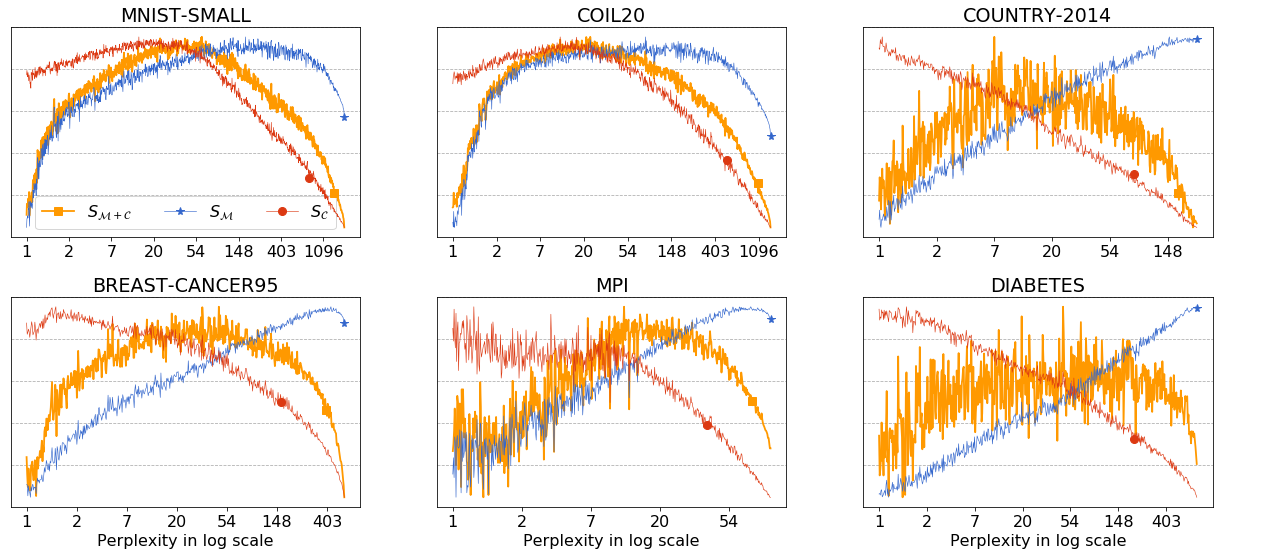

In [290]:
datasets = [
    'MNIST-SMALL',
    'COIL20',
    'COUNTRY-2014',
    'BREAST-CANCER95',
    'MPI',
    'DIABETES'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for i, dataset_name in enumerate(datasets):
    r = i // 3; c = i % 3
    ax = axes[r][c]
    _plot_S(ax, dataset_name, last_row=r==1)

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
# plt.subplots_adjust(hspace=0, wspace=0.2)
plt.savefig('./plots/constraint_scores.pdf'.format(idx+1))

#### Some small notes:
+ $S$ is always small for _very small_ and _very large_ perplexity.
+ $S$ is smooth enough for some datasets but not all. (because of the natural of each dataset, or **my fauts in pre-processing step**)

MNIST-SMALL
Number of perplexity:  898


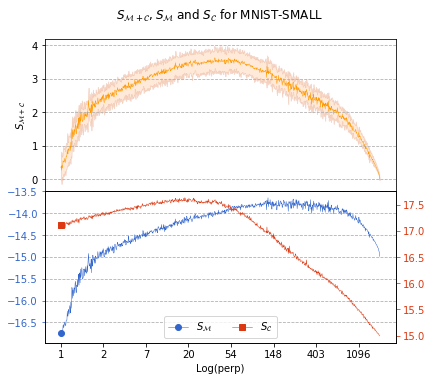

In [24]:
fig, axes = plt.subplots(2,1, figsize=(6,5))
dataset_name = 'MNIST-SMALL'
_plot_S(axes[0], axes[1], dataset_name, in_subplot=False)